In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [2]:
airbnb = pd.read_excel('Airbnb.xlsx')
airbnb.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16847 entries, 0 to 16846
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              16847 non-null  int64         
 1   name                            16837 non-null  object        
 2   description                     16551 non-null  object        
 3   neighborhood_overview           9385 non-null   object        
 4   host_response_time              10811 non-null  object        
 5   host_response_rate              10811 non-null  float64       
 6   host_acceptance_rate            11492 non-null  float64       
 7   host_is_superhost               16824 non-null  object        
 8   host_total_listings_count       16802 non-null  float64       
 9   host_has_profile_pic            16802 non-null  object        
 10  host_identity_verified          16802 non-null  object        
 11  ne

In [3]:
airbnb['description']

0        Beautiful, spacious skylit studio in the heart...
1        Please don鈥檛 expect the luxury here just a bas...
2        This room is up three flights of stairs - it's...
3        <b>The space</b><br />Hi and Thank you for che...
4        Our best guests are seeking a safe, clean, spa...
                               ...                        
16842    LOCATION LOCATION LOCATION!<br />HOBOKEN 2Bdrm...
16843    Private Bedroom for your use, short or long te...
16844    PRIVATE Bedroom in unique SPACIOUS 2Bd Apt<br ...
16845    Our apartment is straight across the river fro...
16846    Very convenient to the Grove St PATH (5 min wa...
Name: description, Length: 16847, dtype: object

In [5]:
errors = pd.read_csv('Error_Analysis.csv')
errors["abs"] = errors["price_diff"].apply(abs)
errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879 entries, 0 to 2878
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   2879 non-null   int64  
 1   id           2879 non-null   int64  
 2   description  2848 non-null   object 
 3   price        2879 non-null   int64  
 4   predict      2879 non-null   float64
 5   price_diff   2879 non-null   float64
 6   abs          2879 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 157.6+ KB


In [6]:
errors_over_100 = errors[errors['abs'] > 100]
errors_below_100 = errors[errors['abs'] <= 100]

In [7]:
descriptions_over = airbnb[airbnb['id'].isin(errors_over_100['id'])]
descriptions_over.reset_index(drop=True, inplace=True)
descriptions_over.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              486 non-null    int64         
 1   name                            486 non-null    object        
 2   description                     478 non-null    object        
 3   neighborhood_overview           290 non-null    object        
 4   host_response_time              384 non-null    object        
 5   host_response_rate              384 non-null    float64       
 6   host_acceptance_rate            397 non-null    float64       
 7   host_is_superhost               486 non-null    object        
 8   host_total_listings_count       486 non-null    float64       
 9   host_has_profile_pic            486 non-null    object        
 10  host_identity_verified          486 non-null    object        
 11  neighb

In [8]:
descriptions_below = airbnb[airbnb['id'].isin(errors_below_100['id'])]
descriptions_below.reset_index(drop=True, inplace=True)
descriptions_below.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2393 entries, 0 to 2392
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              2393 non-null   int64         
 1   name                            2393 non-null   object        
 2   description                     2370 non-null   object        
 3   neighborhood_overview           1387 non-null   object        
 4   host_response_time              1635 non-null   object        
 5   host_response_rate              1635 non-null   float64       
 6   host_acceptance_rate            1723 non-null   float64       
 7   host_is_superhost               2393 non-null   object        
 8   host_total_listings_count       2393 non-null   float64       
 9   host_has_profile_pic            2393 non-null   object        
 10  host_identity_verified          2393 non-null   object        
 11  neig

In [10]:
#filtering out english reviews
from langdetect import detect

def get_en_reviews(x):
    try:
        return detect(x)
    except:
        return None

In [11]:
descriptions_over = descriptions_over[descriptions_over['description'].progress_apply(get_en_reviews) == 'en']

descriptions_below = descriptions_below[descriptions_below['description'].progress_apply(get_en_reviews) == 'en']

100%|██████████| 2393/2393 [00:14<00:00, 167.69it/s]


In [12]:
from nltk import sent_tokenize, word_tokenize
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint

In [13]:
def lda_model(list, num_topics=5, passes=10):

    for i in range(len(list)):
        review = list[i]
        sents = sent_tokenize(review)
        for j in range(len(sents)):
            sent = sents[j]
            sent = sent.strip().replace('\n','')
            sents[j] = sent
        list[i] = '. '.join(sents)

    stops = ['apart','apartment', 'room', 'building', 'space', 'bedroom', 'new york', 'nyc','located', 'york', 'you鈥檒l', 'you鈥檙e']
    texts = [[word for word in story.lower().split()
            if word not in STOPWORDS not in stops and word.isalnum()]
             for story in list]

    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)

    return lda

In [14]:
list_over = descriptions_over['description'].values.tolist()
list_below = descriptions_below['description'].values.tolist()

In [15]:
lda_over = lda_model(list_over)

In [16]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda_over.print_topics(num_words=8))

[   (   0,
        '0.015*"apartment" + 0.009*"central" + 0.008*"room" + 0.008*"new" + '
        '0.007*"located" + 0.007*"living" + 0.007*"kitchen" + 0.006*"york"'),
    (   1,
        '0.018*"apartment" + 0.011*"2" + 0.007*"located" + 0.007*"access" + '
        '0.007*"floor" + 0.006*"street" + 0.006*"nyc" + 0.006*"away"'),
    (   2,
        '0.015*"room" + 0.010*"private" + 0.010*"hotel" + 0.008*"apartment" + '
        '0.007*"times" + 0.007*"2" + 0.007*"central" + 0.006*"check"'),
    (   3,
        '0.016*"new" + 0.010*"located" + 0.010*"york" + 0.009*"city" + '
        '0.009*"home" + 0.008*"space" + 0.008*"apartment" + 0.007*"heart"'),
    (   4,
        '0.026*"apartment" + 0.019*"bedroom" + 0.017*"living" + 0.013*"room" + '
        '0.010*"2" + 0.010*"kitchen" + 0.009*"great" + 0.009*"located"')]


In [17]:
lda_below = lda_model(list_below)
pp.pprint(lda_below.print_topics(num_words=8))

[   (   0,
        '0.034*"apartment" + 0.016*"living" + 0.014*"bedroom" + '
        '0.014*"kitchen" + 0.011*"new" + 0.010*"room" + 0.009*"east" + '
        '0.009*"located"'),
    (   1,
        '0.018*"nyc" + 0.014*"jersey" + 0.014*"city" + 0.012*"steps" + '
        '0.011*"building" + 0.011*"hudson" + 0.010*"amenities" + '
        '0.008*"apartment"'),
    (   2,
        '0.013*"new" + 0.012*"hotel" + 0.010*"york" + 0.010*"state" + '
        '0.009*"square" + 0.009*"times" + 0.009*"enjoy" + 0.008*"located"'),
    (   3,
        '0.009*"equipped" + 0.008*"located" + 0.008*"new" + 0.007*"room" + '
        '0.007*"including" + 0.007*"place" + 0.007*"furnished" + '
        '0.007*"hotel"'),
    (   4,
        '0.022*"room" + 0.020*"apartment" + 0.015*"bedroom" + 0.015*"located" '
        '+ 0.014*"central" + 0.014*"walk" + 0.013*"2" + 0.012*"private"')]


In [18]:
def draw_wordcloud(lda,topicnum,min_size=0,STOPWORDS=[]):
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=50):
        prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=50):
        if word in STOPWORDS or  len(word) < min_size:
            continue

        freq = int(prob/prob_total*100)
        alist=[word]
        word_list.extend(alist*freq)

    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    %matplotlib inline
    from random import shuffle
    shuffle(word_list)
    text = ' '.join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=20).generate(text)

    plt.axis('off')
    plt.imshow(wordcloud)

    return None

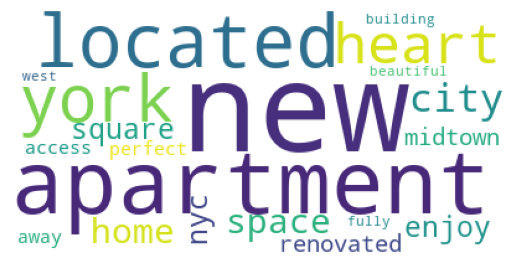

In [19]:
draw_wordcloud(lda_over, 3)

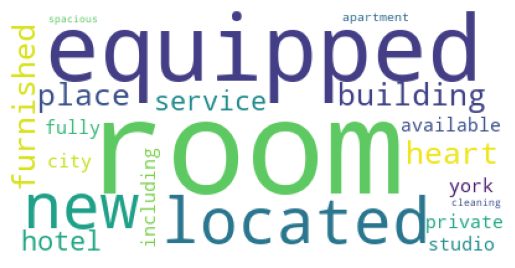

In [20]:
draw_wordcloud(lda_below,3)